# CHARISMA: Demonstration of Chada wavenumber calibration

In [1]:
from ramanchada import chada,chada_utilities,chada_io


Create a CHADA archive from native Raman file

In [2]:
import os,os.path

#Set paths
import os, os.path, shutil

TEST_FILES = "test"
HOME=os.path.expanduser("~")

if os.name == 'nt':
     HOME = os.path.join(os.path.expanduser("~"),"Desktop")


In [3]:
#DATA_FILES = r"\\vm-stor-51\alle\Projekte Kunststoffe\RD\MA\Öffentliche_Projekte\2020-01-07_230007_H2020-CHARISMA_barton\Python\charisma-raman-spectrum-harmonization\test_data\\"
DATA_FILES = TEST_FILES
source_file = os.path.join(TEST_FILES,"200218-17.wdf")

assert os.path.exists(source_file),"{} does not exist!".format(source_file)

In [4]:
chada_file = os.path.join(TEST_FILES,"200218-17.cha")
chada_io.create(source_file, chada_file)
assert os.path.exists(chada_file),"{} does not exist!".format(chada_file)

## 1. Generate calibration using a reference spectrum with equal wavenumber range

Load CHADA archive into Chada object

In [5]:
C = chada.Chada(chada_file)

Show unprocessed data

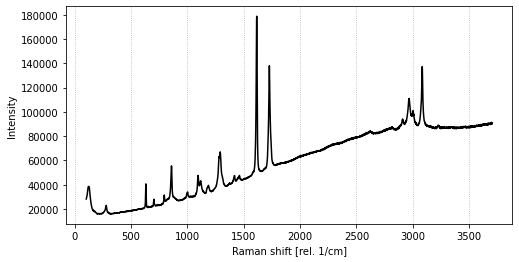

In [6]:
C.plot()

Now separate a baseline

In [7]:
#C.baseline()
C.fit_baseline()
C.remove_baseline()

The data has been updated

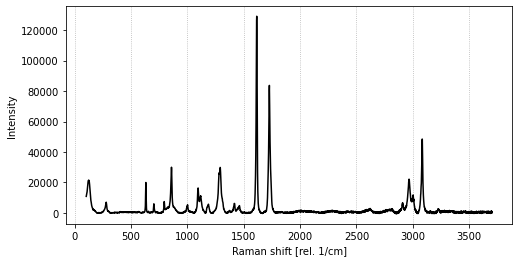

In [8]:
C.plot()

Crop spectrum k direction

In [9]:
C.x_crop(500, 2500)

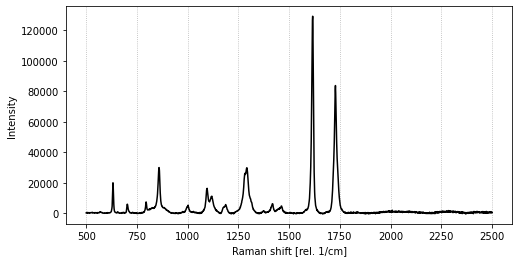

In [10]:
C.plot()

Area normalization

In [11]:
C.normalize('area')

commit saves the CHADA

In [12]:
C.commit('unshifted')

In [13]:
print(C.path,C.commits)

test/200218-17.cha ['Generated CHADA on Wed May 26 10:57:58 2021', 'unshifted']



Now, a copy of the unshifted CHADA is made and saved as "C:\Users\barton\Desktop\chada\200218-17_shifted.cha"

> NJ - is it supposed to be manual copy outside the notebook ?  Added a cell to do so


In [14]:
from shutil import copyfile

shifted_path = C.path.replace(".cha","_shifted.cha")
copyfile(C.path,shifted_path)
C.path = shifted_path

In [15]:
_shift=5
print("Shift spectrum in x direction by a constant {} rel. 1/cm".format(_shift))

Shift spectrum in x direction by a constant 5 rel. 1/cm


In [16]:
import numpy as np
C.shiftX(np.ones_like(C.x_data)*_shift)

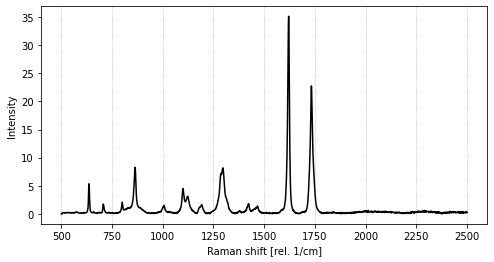

In [17]:
C.plot()

In [18]:
 
C.path
print("commit saves the shifted CHADA to {}".format(C.path))

commit saves the shifted CHADA to test/200218-17_shifted.cha


In [19]:
C.commit('shifted')


In [20]:
print(C.path,C.commits)

test/200218-17_shifted.cha ['Generated CHADA on Wed May 26 10:57:58 2021', 'unshifted', 'shifted']


A CHADA Group can be used to show the relative shift

In [21]:

G = chada.ChadaGroup([chada_file,shifted_path])

In [22]:
#%matplotlib notebook

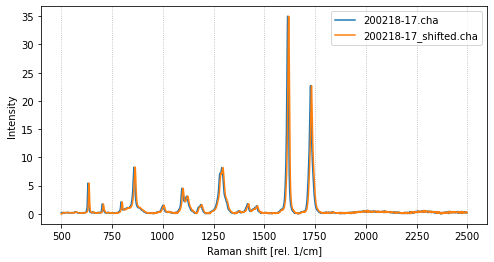

In [23]:
G.plot()

In [24]:
from ramanchada import chada_calibration

The shifts between both CHADA files is calculated

In [25]:
peak_pos, shift_pos, _ = chada_calibration.makeXCalFromSpec(shifted_path, chada_file, bounds=[-10.,10.])

Saved calibration file 'test/200218-17_shifted.chacal'


In [26]:
#one shift for each peak
for shift in shift_pos:
    print(shift,abs(shift + _shift))
    assert abs(shift + _shift)<=1e-2    

-5.006572205146047 0.006572205146047061
-5.000227547045691 0.00022754704569116768
-5.002537279240377 0.002537279240376833
-5.009003430250957 0.0090034302509574
-5.000315393801012 0.0003153938010118651
-4.995333660611938 0.004666339388061935


~5 rel. 1/cm is the correct result !

The function makeXCalFromSpec() correctly finds the top-hat shift function that was applied

The CHADA method .XCal() calibrates the current CHADA using the determined shift anchors (orange circles).

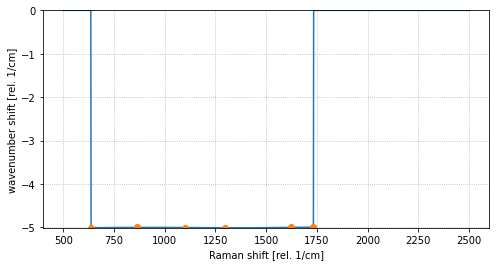

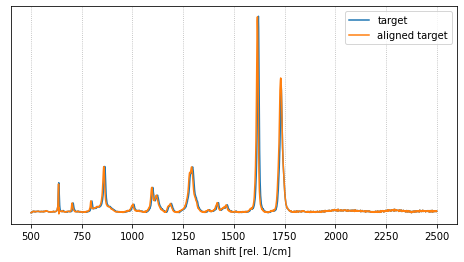

In [27]:
C.XCal(peak_pos, shift_pos, show=True)

## 2. Generate calibration using a reference spectrum with different wavenumber range

The CHADA is reset to the raw state

In [28]:
C.rewind(0)

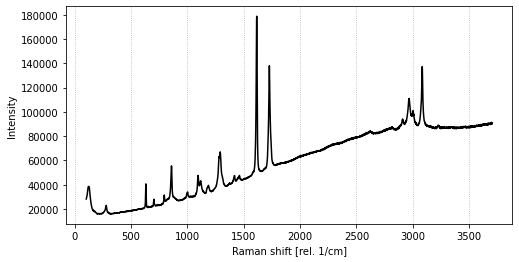

In [29]:
C.plot()

In [30]:
print(C.baseline)
#C.baseline()
# C.baseline is an array, not a function and returns error 'numpy.ndarray' object is not callable
C.fit_baseline()
C.remove_baseline()
C.normalize()

[17507.10143925 17487.80445678 17468.50757843 ... 90149.50217256
 90163.49559463 90177.48894868]


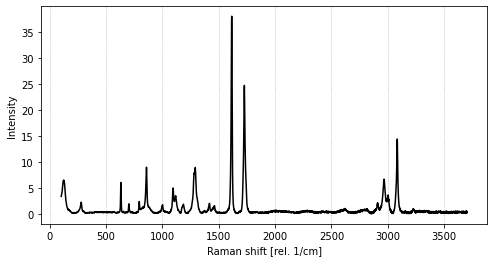

In [31]:
C.plot()

A baseline-corrected and normalized version is stored, this time with full wavenumber range.

In [32]:
C.commit('rewind')

In [33]:
from shutil import copyfile

target_path = chada_file.replace(".cha","_target.cha")
copyfile(C.path,target_path)

print(target_path)

test/200218-17_target.cha


In [34]:
print("Now, a copy of the unshifted CHADA is made as '{}', and loaded from disk into CHADA Cs".format(target_path))

Now, a copy of the unshifted CHADA is made as 'test/200218-17_target.cha', and loaded from disk into CHADA Cs


In [35]:
Cs = chada.Chada(target_path)

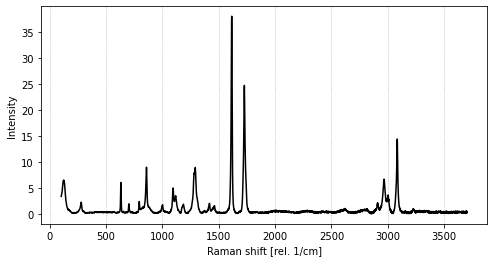

In [36]:
Cs.plot()

The target data is cropped

In [37]:
Cs.x_crop(500, 1500)

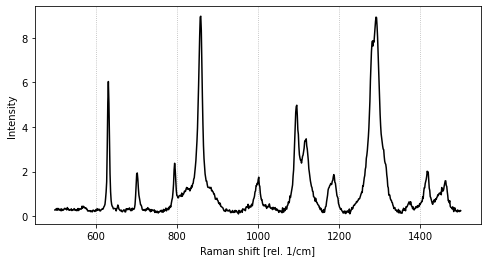

In [38]:
Cs.plot()

In [39]:
Cs.shiftX(np.ones_like(Cs.x_data)*5)

commit saves the cropped CHADA.

In [40]:
Cs.commit('shifted')

The shifts between both CHADA files is calculated

In [41]:
peak_pos, shift_pos, _ = chada_calibration.makeXCalFromSpec(target_path, chada_file, bounds=[-10.,10.])

Saved calibration file 'test/200218-17_target.chacal'


In [42]:
shift_pos

array([ -4.9812809 ,  -5.17973851,  -4.29563286,  -4.98321863,
       -10.        ,  -6.65087329,  10.        , -10.        ,
        -3.39974737, -10.        ,  10.        ])

The function makeXCalFromSpec() correctly finds the top-hat shift function that was applied

The CHADA method .XCal() calibrates the current CHADA using the determined shift anchors (orange circles).

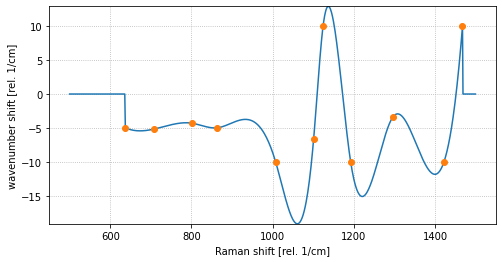

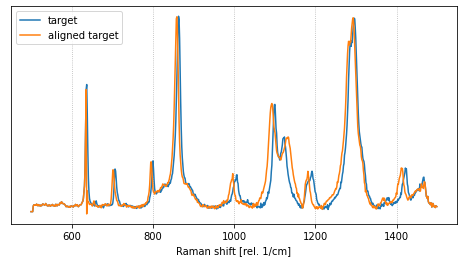

In [43]:
Cs.XCal(peak_pos, shift_pos, show=True)

## 3. Generate calibration with non-constant wavenumber shift using a reference spectrum with different wavenumber range

This time, a ramp-shaped shift is applied from 0 to 5 rel. 1/cm

In [44]:
Cs.shiftX(np.linspace(0, 5, len(Cs.x_data)))

In [45]:
Cs.commit('shifted')

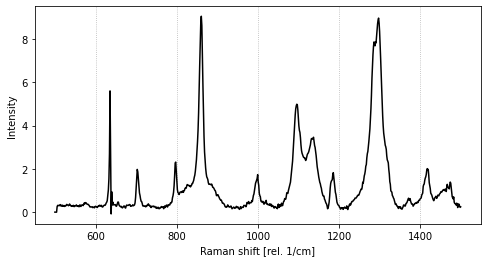

In [46]:
Cs.plot()

The shifts between both CHADA files is calculated. Remember, "C:\Users\barton\Desktop\chada\200218-17.cha" already has a constant shift of 5 rel. 1/cm! 

In [47]:
peak_pos, shift_pos, _ = chada_calibration.makeXCalFromSpec(target_path, chada_file, bounds=[-10.,10.])

Saved calibration file 'test/200218-17_target.chacal'


In [48]:
shift_pos

array([ -3.57374902,  -3.4108126 ,  -1.25592957,  10.        ,
        -1.79915727,  -0.6313071 ,  -0.77639809,  10.        ,
       -10.        ,  -2.93471833, -10.        ,  10.        ])

The relative shift function, a top hat plus ramp, is correctly determined and compensated by the .XCal() method.

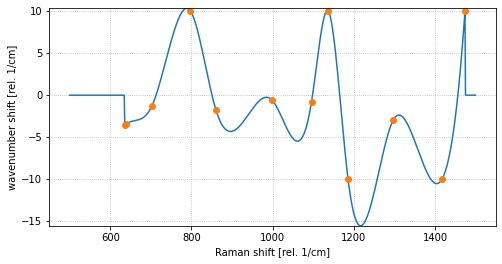

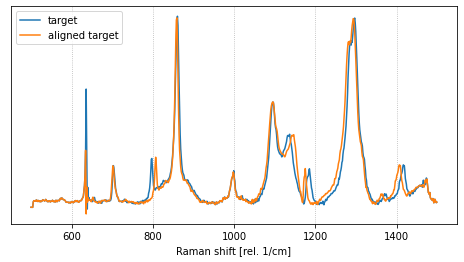

In [49]:
Cs.XCal(peak_pos, shift_pos, show=True)

In [50]:
Cs.commit('calibrated with ramp shift')